### Llibreries

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
import joblib
import scikitplot as skplt

from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### Funcions

Inicialitzem i guardem les funcions per fer el face mesh.
El 'index_lips' són tots els punts que defineixen els llavis.
 I el 'index_eyes' són els punts que estan en la part central dels ulls per poder calcular la distància interpupil·lar en el nostre cas.

In [2]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
index_lips = [61, 76, 62, 78, 
              185, 184, 183, 191, 95, 96, 77, 146, 
              40, 74, 42, 80, 88, 89, 90, 91, 
              39, 73, 41, 81, 178, 179, 180, 181, 
              37, 72, 38, 82, 87, 86, 85, 84,
              0, 11, 12, 13, 14, 15, 16, 17,
              267, 302, 268, 312, 317, 316, 315, 314, 
              269, 303, 271, 311, 402, 403, 404, 405, 
              270, 304, 272, 310, 318, 319, 320, 321, 
              409, 408, 407, 415, 324, 325, 307, 375, 
              308, 292, 306, 291]
index_eyes = [159, 386]

## Vowel Recognition amb la referència de la distància interpupil·lar

### Creació del dataset

In [3]:
carpeta_principal = 'data/img/'
vocales_info_b = []
img_lip_info_b = []

eyes_info = []
img_eyes_info = []
distance_eye = []

for entrada in os.listdir(carpeta_principal):
    ruta_absoluta = os.path.join(carpeta_principal, entrada)
    # Verifica si la entrada es una carpeta
    if os.path.isdir(ruta_absoluta):
        # Ruta de la carpeta que contiene las imágenes
        carpeta = 'data/img/' + entrada

    # Itera sobre todos los archivos en la carpeta
    for archivo in os.listdir(carpeta):
        # Verifica si el archivo es una imagen
        if archivo.endswith('.jpg') or archivo.endswith('.png') or archivo.endswith('.jpeg'):
            ruta_imagen = os.path.join(carpeta, archivo)
        
            with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
                lip_info = []
                lip_info_b = []
                eyes_info = []
                image = cv2.imread(ruta_imagen)
                height, width, _ = image.shape
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = face_mesh.process(image_rgb)

                if results.multi_face_landmarks is not None:
                    for face_landmarks in results.multi_face_landmarks:
                        for index in index_lips:
                            #lip_info.append(face_landmarks.landmark[index])
                            lip_info_b.append([face_landmarks.landmark[index].x, face_landmarks.landmark[index].y])
                        for index in index_eyes:
                            eyes_info.append([face_landmarks.landmark[index].x, face_landmarks.landmark[index].y])

                pos_x = []
                pos_y = []
                for i in lip_info_b:
                    pos_x.append(i[0])
                    pos_y.append(i[1])

                aux_x = np.mean(pos_x)
                aux_y = np.mean(pos_y)
                lip_info_b.append([aux_x, aux_y])
        
        img_lip_info_b.append(lip_info_b)
        img_eyes_info.append(eyes_info)
    vocales_info_b.append(img_lip_info_b)
    distance_eye.append(img_eyes_info)
    img_lip_info_b = []
    img_eyes_info = []

In [4]:
distance_eye[0][0][0]

[0.33143967390060425, 0.4065207839012146]

In [5]:
len_file = len(vocales_info_b[0])
len_file

251

In [6]:
len_vi = len(vocales_info_b)
len_vi

20

In [7]:
for i in vocales_info_b:
    print(len(i))

251
137
132
241
218
137
144
239
268
137
152
236
318
137
143
227
311
137
157
253


In [8]:
for i in distance_eye:
    print(len(i))

251
137
132
241
218
137
144
239
268
137
152
236
318
137
143
227
311
137
157
253


In [9]:
min = 1000
for i in vocales_info_b:
    if (len(i) < min) and (len(i) > 0):
        min = len(i)
        
for i in range(len(vocales_info_b)):
    vocales_info_b[i] = vocales_info_b[i][:min]
    distance_eye[i] = distance_eye[i][:min]
    
for i in vocales_info_b:
    print(len(i))

132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132


In [10]:
vocales_info_np_b = np.array(vocales_info_b)
distance_eye_np = np.array(distance_eye)

In [11]:
vocales_info_np_b[0][0][0]

array([0.33191043, 0.5779357 ])

In [12]:
distance_eye_np[0][0][0]

array([0.33143967, 0.40652078])

In [13]:
coordenada_central = 80
distancia_media_ojos = 63 #En milimetros
vocales_info_b_2 = []
img_lip_info_b_2 = []
for i in range(len(vocales_info_np_b)):
    for j in range(len(vocales_info_np_b[i])):
        lip_info_b_2 = []
        distancia_ojos = np.linalg.norm(distance_eye_np[i][j][0] - distance_eye_np[i][j][1])
        #print("distancia_ojos:", distancia_ojos)
        escala_ojos = distancia_media_ojos / distancia_ojos
        #print("escala_ojos:", escala_ojos)
        for k in range(len(vocales_info_np_b[i][j]) - 1):
            distancia = np.linalg.norm(vocales_info_np_b[i][j][k] - vocales_info_np_b[i][j][coordenada_central])
            #print("distancia:", distancia)
            #print("distancia final:", (distancia * escala_ojos))
            lip_info_b_2.append(distancia * escala_ojos)
        img_lip_info_b_2.append(lip_info_b_2)
    vocales_info_b_2.append(img_lip_info_b_2)
    img_lip_info_b_2 = []

In [15]:
longitud_array_vocals = min*len_vi
aux_a_v = 0

array_vocals = []
for i in range(longitud_array_vocals):
    if i % (longitud_array_vocals/5) == 0:
        aux_a_v += 1  
    array_vocals.append(aux_a_v)

df_array_vocals = pd.DataFrame(array_vocals, columns=['Y'])
df_array_vocals

,Y
0,1
1,1
2,1
3,1
4,1
...,...
2635,5
2636,5
2637,5
2638,5


In [17]:
df_2 = pd.DataFrame()
for i in range(len(vocales_info_b_2)):
    df_aux = pd.DataFrame(vocales_info_b_2[i])
    df_2 = pd.concat([df_2, df_aux])

In [18]:
df_2

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,24.704277,22.987331,21.258266,20.311675,27.028833,24.411226,21.759922,20.962155,17.206931,19.412249,...,21.250146,20.586484,20.419455,22.321419,24.280929,26.204838,22.419959,23.328695,25.021044,26.684171
1,25.328202,23.658986,21.945276,20.977384,27.918306,25.275622,22.625037,21.827484,17.343523,19.502605,...,21.930245,21.220622,21.368155,23.245079,25.202338,27.120472,23.468093,24.412196,26.120263,27.751889
2,24.186847,22.532038,20.860433,19.966992,26.637630,24.008625,21.381509,20.608466,16.622070,18.749095,...,20.963926,20.277508,20.478139,22.343140,24.319401,26.301764,22.598314,23.500431,25.184281,26.822184
3,23.809632,22.111871,20.414592,19.531865,25.947102,23.301017,20.659152,19.857945,16.525044,18.645876,...,20.389423,19.691396,19.757427,21.626787,23.640273,25.672468,21.849467,22.712839,24.396980,26.058318
4,24.489670,22.817459,21.125398,20.203400,26.848786,24.225216,21.604975,20.835183,16.964380,19.102633,...,21.092329,20.402062,20.512078,22.391121,24.372976,26.325102,22.528806,23.456389,25.160640,26.798628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,18.884746,17.376455,16.050952,15.513441,17.844859,16.026751,14.089634,12.857213,13.565966,14.756534,...,14.419796,13.158582,13.601821,14.857927,16.400059,18.038213,15.676006,16.339165,17.687736,19.272494
128,18.507943,16.981797,15.641538,15.102797,17.500898,15.660263,13.702368,12.474689,13.195015,14.381402,...,13.884929,12.631497,13.094748,14.350195,15.886699,17.512706,15.043970,15.684505,17.026631,18.605317
129,18.403381,16.879805,15.537278,15.004871,17.383857,15.562786,13.614093,12.380865,13.122244,14.320604,...,13.798729,12.544160,13.038704,14.289590,15.832345,17.461468,14.979654,15.623428,16.980063,18.577581
130,18.914665,17.428339,16.134304,15.620854,17.860468,16.071381,14.171264,12.967229,13.610958,14.768214,...,14.404760,13.154577,13.581471,14.800923,16.303300,17.904713,15.649748,16.295305,17.616820,19.182438


### Entrenament del model Support Vector Machine

In [21]:
# Definir los parámetros a ajustar
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf', 'poly']}

# Realizar la búsqueda en cuadrícula para encontrar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(df_2, df_array_vocals.values.ravel())

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [22]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_2, df_array_vocals.values.ravel(), test_size=0.2, random_state=42)

# Crear un clasificador SVM
svm_classifier_2 = SVC(kernel='rbf', C=10, gamma=0.01)

# Entrenar el clasificador
svm_classifier_2.fit(X_train, y_train)

# Predecir las etiquetas de clase para el conjunto de prueba
y_pred = svm_classifier_2.predict(X_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9867424242424242


<Axes: title={'center': 'Confusion Matrix SVM'}, xlabel='Predicted label', ylabel='True label'>

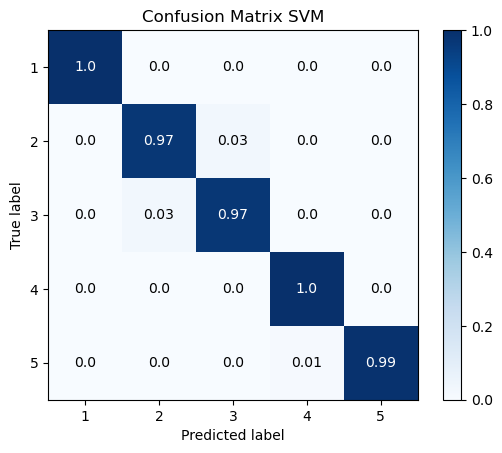

In [23]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred, 
    normalize=True,
    title='Confusion Matrix SVM')

In [24]:
# Guardar el modelo
dump(svm_classifier_2, 'models/svm/svm_classifier_eyes.joblib')

['model/svm/svm_classifier_eyes.joblib']

In [25]:
# Realizar validación cruzada para evaluar el rendimiento del modelo SVM
scores = cross_val_score(SVC(), df_2, df_array_vocals.values.ravel(), cv=5)
print("Precisión de validación cruzada:", scores.mean())

Precisión de validación cruzada: 0.7628787878787878


### Entrenament del model Random Forest

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_2, df_array_vocals.values.ravel(), test_size=0.2, random_state=42)

rf_classifier_2 = RandomForestClassifier(n_estimators=1000, random_state=42)

rf_classifier_2.fit(X_train, y_train)

y_pred = rf_classifier_2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9810606060606061


<Axes: title={'center': 'Confusion Matrix Random Forest'}, xlabel='Predicted label', ylabel='True label'>

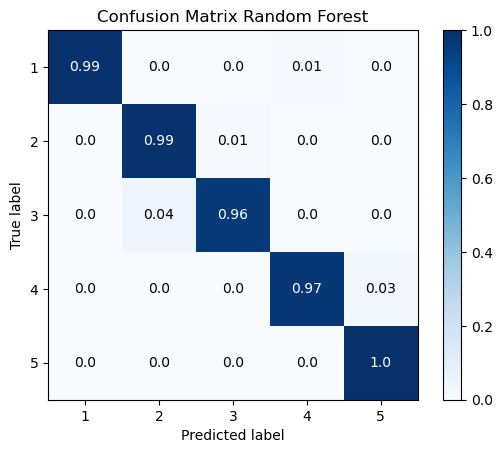

In [27]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred, 
    normalize=True,
    title='Confusion Matrix Random Forest')

In [28]:
# Guardar el modelo
dump(rf_classifier_2, 'models/rf/rf_classifier_eyes.joblib')

['model/rf/rf_classifier_eyes.joblib']